In [1]:
from langchain_core.messages.utils import trim_messages, count_tokens_approximately
from langchain_core.messages import BaseMessage
from langmem.short_term import SummarizationNode, RunningSummary
from langchain_core.messages import AnyMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langchain_core.tools import tool
from typing import TypedDict,Annotated
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.graph.message import add_messages

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
class State(TypedDict):
    messages : Annotated[list[BaseMessage],add_messages]
    context: dict[str, RunningSummary]   #expected by the SummarizationNode

class LLMInputState(TypedDict):
    summarized_messages: list[AnyMessage]
    context: dict[str, RunningSummary] 

In [4]:
model = ChatGoogleGenerativeAI(model = 'gemini-1.5-flash')
summarization_model = model.bind(max_tokens = 524)

In [5]:
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')

In [6]:
summarization_node = SummarizationNode(
    token_counter=count_tokens_approximately,
    model= summarization_model,
    max_tokens=1028,
    max_tokens_before_summary=1028,
    max_summary_tokens=524
    

)

In [7]:
system_prompt = f"""
You are an helping agent that helps users with natural conversation 


### Style & Tone
- Be concise but complete.
- Use plain language that non-technical users can understand.
- If user input is ambiguous, ask clarifying questions before acting.
- Never hallucinate outputs. If unsure, say so.
"""

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def planner_node(state: LLMInputState):

    planner_prompt = ChatPromptTemplate([
        ('system',system_prompt),
        MessagesPlaceholder(variable_name='messages')
    ])


    planner = planner_prompt | llm
    result = planner.invoke({'messages': state["summarized_messages"]})


    return ({'messages':[result]}) 
    

In [9]:
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

In [10]:
builder = StateGraph(State)
builder.add_node(planner_node)
builder.add_node("summarize",summarization_node)

builder.add_edge(START,'summarize')
builder.add_edge("summarize", "planner_node")
builder.add_edge('planner_node',END)
graph = builder.compile(checkpointer=checkpointer)

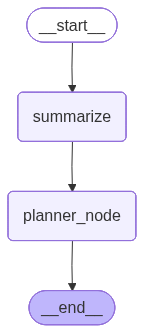

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
# Invoke the graph
config = {"configurable": {"thread_id": "1"}}

In [27]:
graph.invoke({"messages": "what is my name"}, config)

c:\Users\JunaidKhan\Desktop\aai_project\myenv\Lib\site-packages\langmem\short_term\summarization.py:246: RuntimeWarning: Failed to trim messages to fit within max_tokens limit before summarization - falling back to the original message list. This may lead to exceeding the context window of the summarization LLM.
  warnings.warn(


{'messages': [HumanMessage(content='hi, my name is bob', additional_kwargs={}, response_metadata={}, id='d3748592-a06f-4501-b1d9-56f27f25b1c2'),
  AIMessage(content="Hi Bob, it's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--f941bfa5-7044-4ddd-b2e5-187a0fad9803-0', usage_metadata={'input_tokens': 73, 'output_tokens': 34, 'total_tokens': 107, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 16}}),
  HumanMessage(content='write a 4 paragraph poem about cats', additional_kwargs={}, response_metadata={}, id='ae76cec6-6547-4804-a5d8-41ba42f73805'),
  AIMessage(content="With silent paws and eyes of emerald green,\nA creature of comfort, often serene.\nThey stretch and yawn, a picture of grace,\nEach whisker twitching, a curious face.\nA gentle purr, a rumbling, soft soun

In [14]:
graph.invoke({"messages": "write a 4 paragraph poem about cats"}, config)

{'messages': [HumanMessage(content='hi, my name is bob', additional_kwargs={}, response_metadata={}, id='d3748592-a06f-4501-b1d9-56f27f25b1c2'),
  AIMessage(content="Hi Bob, it's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--f941bfa5-7044-4ddd-b2e5-187a0fad9803-0', usage_metadata={'input_tokens': 73, 'output_tokens': 34, 'total_tokens': 107, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 16}}),
  HumanMessage(content='write a 4 paragraph poem about cats', additional_kwargs={}, response_metadata={}, id='ae76cec6-6547-4804-a5d8-41ba42f73805'),
  AIMessage(content="With silent paws and eyes of emerald green,\nA creature of comfort, often serene.\nThey stretch and yawn, a picture of grace,\nEach whisker twitching, a curious face.\nA gentle purr, a rumbling, soft soun

In [15]:
graph.invoke({"messages": "now do the same but for dogs"}, config)

{'messages': [HumanMessage(content='hi, my name is bob', additional_kwargs={}, response_metadata={}, id='d3748592-a06f-4501-b1d9-56f27f25b1c2'),
  AIMessage(content="Hi Bob, it's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--f941bfa5-7044-4ddd-b2e5-187a0fad9803-0', usage_metadata={'input_tokens': 73, 'output_tokens': 34, 'total_tokens': 107, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 16}}),
  HumanMessage(content='write a 4 paragraph poem about cats', additional_kwargs={}, response_metadata={}, id='ae76cec6-6547-4804-a5d8-41ba42f73805'),
  AIMessage(content="With silent paws and eyes of emerald green,\nA creature of comfort, often serene.\nThey stretch and yawn, a picture of grace,\nEach whisker twitching, a curious face.\nA gentle purr, a rumbling, soft soun

In [16]:
graph.invoke({"messages": "Write a 1000 words blog on dog vs cat"}, config)


{'messages': [HumanMessage(content='hi, my name is bob', additional_kwargs={}, response_metadata={}, id='d3748592-a06f-4501-b1d9-56f27f25b1c2'),
  AIMessage(content="Hi Bob, it's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--f941bfa5-7044-4ddd-b2e5-187a0fad9803-0', usage_metadata={'input_tokens': 73, 'output_tokens': 34, 'total_tokens': 107, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 16}}),
  HumanMessage(content='write a 4 paragraph poem about cats', additional_kwargs={}, response_metadata={}, id='ae76cec6-6547-4804-a5d8-41ba42f73805'),
  AIMessage(content="With silent paws and eyes of emerald green,\nA creature of comfort, often serene.\nThey stretch and yawn, a picture of grace,\nEach whisker twitching, a curious face.\nA gentle purr, a rumbling, soft soun

In [17]:
graph.invoke({"messages": "What happened to big dogs as compared to big cats like tiger,lion etc"}, config)

c:\Users\JunaidKhan\Desktop\aai_project\myenv\Lib\site-packages\langmem\short_term\summarization.py:246: RuntimeWarning: Failed to trim messages to fit within max_tokens limit before summarization - falling back to the original message list. This may lead to exceeding the context window of the summarization LLM.
  warnings.warn(


{'messages': [HumanMessage(content='hi, my name is bob', additional_kwargs={}, response_metadata={}, id='d3748592-a06f-4501-b1d9-56f27f25b1c2'),
  AIMessage(content="Hi Bob, it's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--f941bfa5-7044-4ddd-b2e5-187a0fad9803-0', usage_metadata={'input_tokens': 73, 'output_tokens': 34, 'total_tokens': 107, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 16}}),
  HumanMessage(content='write a 4 paragraph poem about cats', additional_kwargs={}, response_metadata={}, id='ae76cec6-6547-4804-a5d8-41ba42f73805'),
  AIMessage(content="With silent paws and eyes of emerald green,\nA creature of comfort, often serene.\nThey stretch and yawn, a picture of grace,\nEach whisker twitching, a curious face.\nA gentle purr, a rumbling, soft soun

In [20]:
graph.invoke({"messages": "batman"}, config)


{'messages': [HumanMessage(content='hi, my name is bob', additional_kwargs={}, response_metadata={}, id='d3748592-a06f-4501-b1d9-56f27f25b1c2'),
  AIMessage(content="Hi Bob, it's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--f941bfa5-7044-4ddd-b2e5-187a0fad9803-0', usage_metadata={'input_tokens': 73, 'output_tokens': 34, 'total_tokens': 107, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 16}}),
  HumanMessage(content='write a 4 paragraph poem about cats', additional_kwargs={}, response_metadata={}, id='ae76cec6-6547-4804-a5d8-41ba42f73805'),
  AIMessage(content="With silent paws and eyes of emerald green,\nA creature of comfort, often serene.\nThey stretch and yawn, a picture of grace,\nEach whisker twitching, a curious face.\nA gentle purr, a rumbling, soft soun

In [28]:
final_response = graph.invoke({"messages": "my name is jay"}, config)

In [29]:
final_response["messages"][-1].pretty_print()
print("\nSummary:", final_response["context"]["running_summary"].summary)

================================== Ai Message ==================================

Okay, I've noted that! Thanks for letting me know, Jay.

Summary: The conversation began with a simple greeting and then unexpectedly veered into the realm of professional wrestling.  After initial inquiries about the identities of Charlotte Flair and Mercedes Moné, the discussion shifted to a more technical topic:  "Human-in-the-Loop LangGraph," focusing on the integration of human oversight within large language model (LLM) applications using the LangGraph framework. This involved a detailed explanation of the concept, its benefits, implementation, and illustrative examples.  Prior to this, the conversation included a four-paragraph poem about cats, followed by a similar poem about dogs, and culminated in a hypothetical 1000-word blog post comparing and contrasting the two animals.  Finally, a summary of the entire conversation, including the wrestling and LangGraph segments, was requested and provided.